In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras import regularizers

In [4]:
data=pd.read_csv('/content/drive/MyDrive/미래에셋/final_sk.csv')

data.index = data["Date"]
data.drop("Date", axis = 1, inplace = True)
data

,Open,High,Low,Close,Volume,Change,5MA,5Disparity,20MA,20Disparity,60MA,60Disparity,120MA,120Disparity,label
Date,,,,,,,,,,,,,,,
2021-06-01,265000,272000,265000,268500,154636,0.013208,265300.0,1.012062,271550.0,0.988768,272850.000000,0.984057,277604.166667,0.967205,-1.000000
2021-06-02,268500,271500,266500,270500,146791,0.007449,266000.0,1.016917,271375.0,0.996776,273108.333333,0.990449,277862.500000,0.973503,-1.000000
2021-06-03,270000,274500,270000,272000,192929,0.005545,268300.0,1.013791,271025.0,1.003597,273483.333333,0.994576,278141.666667,0.977919,-1.000000
2021-06-04,270000,273500,268000,270000,160789,-0.007353,269200.0,1.002972,270500.0,0.998152,273916.666667,0.985701,278362.500000,0.969958,-1.000000
2021-06-07,272500,272500,268500,271000,123611,0.003704,270400.0,1.002219,269925.0,1.003983,274258.333333,0.988119,278575.000000,0.972808,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,148900,150800,148900,150300,89644,0.010081,150420.0,0.999202,159430.0,0.942733,171975.000000,0.873964,173928.333333,0.864149,0.300000
2024-05-28,150300,150800,148600,149000,122461,-0.008649,149940.0,0.993731,158815.0,0.938199,171366.666667,0.869481,173781.666667,0.857398,0.300000
2024-05-29,148100,149400,144400,144700,273090,-0.028859,148580.0,0.973886,157880.0,0.916519,170551.666667,0.848423,173615.000000,0.833453,0.300000


In [5]:
TARGET = "Close"
SEQ_SIZE = 30    # 10/30/60
PRED_SIZE = 1
LEARNING_RATE = 0.0001
EPOCH = 30
BATCH_SIZE = 8

In [6]:
def split_xy(dataset, time_steps, y_column):
    x, y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column

        if y_end_number > len(dataset):
            break
        tmp_x = dataset.iloc[i:x_end_number, :]
        tmp_y = dataset.iloc[x_end_number:y_end_number, :].loc[:, TARGET]
        x.append(tmp_x.values)
        y.append(tmp_y.values)

    return np.array(x), np.array(y)

X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
print(X[0],"\n", y[0])
print("X size : ", X.shape)
print("y size : ", y.shape)

[[ 2.65000000e+05  2.72000000e+05  2.65000000e+05  2.68500000e+05
   1.54636000e+05  1.32075472e-02  2.65300000e+05  1.01206182e+00
   2.71550000e+05  9.88768183e-01  2.72850000e+05  9.84057174e-01
   2.77604167e+05  9.67204503e-01 -1.00000000e+00]
 [ 2.68500000e+05  2.71500000e+05  2.66500000e+05  2.70500000e+05
   1.46791000e+05  7.44878957e-03  2.66000000e+05  1.01691729e+00
   2.71375000e+05  9.96775679e-01  2.73108333e+05  9.90449455e-01
   2.77862500e+05  9.73503082e-01 -1.00000000e+00]
 [ 2.70000000e+05  2.74500000e+05  2.70000000e+05  2.72000000e+05
   1.92929000e+05  5.54528651e-03  2.68300000e+05  1.01379053e+00
   2.71025000e+05  1.00359745e+00  2.73483333e+05  9.94576147e-01
   2.78141667e+05  9.77918926e-01 -1.00000000e+00]
 [ 2.70000000e+05  2.73500000e+05  2.68000000e+05  2.70000000e+05
   1.60789000e+05 -7.35294118e-03  2.69200000e+05  1.00297177e+00
   2.70500000e+05  9.98151571e-01  2.73916667e+05  9.85701247e-01
   2.78362500e+05  9.69958238e-01 -1.00000000e+00]
 [ 2

In [7]:
# 시퀀스별로 Min-Max 정규화
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        # 시퀀스 내에서 각 피쳐의 최소값과 최대값 계산
        min_val = np.min(X[i, :, j])
        max_val = np.max(X[i, :, j])
        if min_val == max_val:
            X[i, :, j] = 0
        else:
            X[i, :, j] = (X[i, :, j] - min_val) / (max_val - min_val)

# 결과 확인
print(X.shape)

(710, 30, 15)


In [8]:
# train,test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[[ 2.65000000e+05  2.72000000e+05  2.65000000e+05  2.68500000e+05
   1.54636000e+05  1.32075472e-02  2.65300000e+05  1.01206182e+00
   2.71550000e+05  9.88768183e-01  2.72850000e+05  9.84057174e-01
   2.77604167e+05  9.67204503e-01 -1.00000000e+00]
 [ 2.68500000e+05  2.71500000e+05  2.66500000e+05  2.70500000e+05
   1.46791000e+05  7.44878957e-03  2.66000000e+05  1.01691729e+00
   2.71375000e+05  9.96775679e-01  2.73108333e+05  9.90449455e-01
   2.77862500e+05  9.73503082e-01 -1.00000000e+00]
 [ 2.70000000e+05  2.74500000e+05  2.70000000e+05  2.72000000e+05
   1.92929000e+05  5.54528651e-03  2.68300000e+05  1.01379053e+00
   2.71025000e+05  1.00359745e+00  2.73483333e+05  9.94576147e-01
   2.78141667e+05  9.77918926e-01 -1.00000000e+00]
 [ 2.70000000e+05  2.73500000e+05  2.68000000e+05  2.70000000e+05
   1.60789000e+05 -7.35294118e-03  2.69200000e+05  1.00297177e+00
   2.70500000e+05  9.98151571e-01  2.73916667e+05  9.85701247e-01
   2.78362500e+05  9.69958238e-01 -1.00000000e+00]
 [ 2

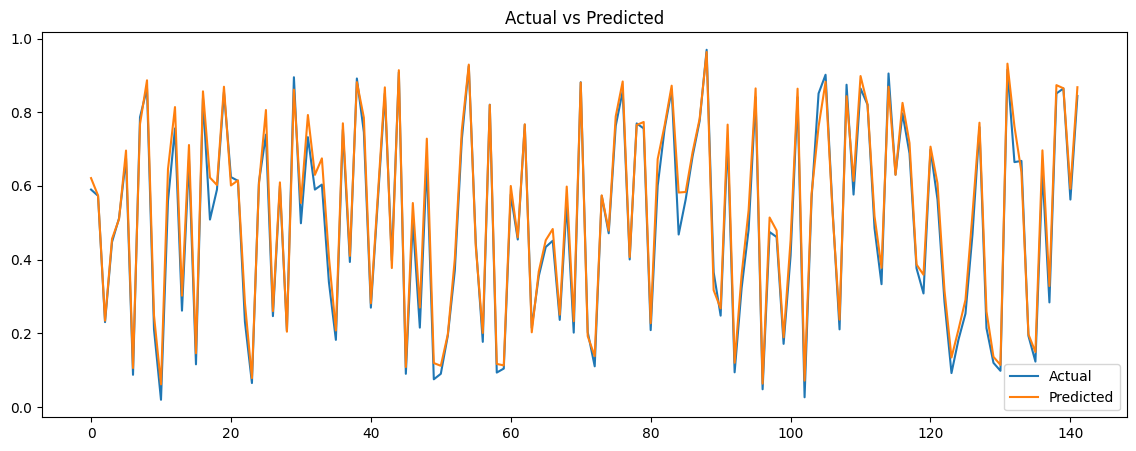

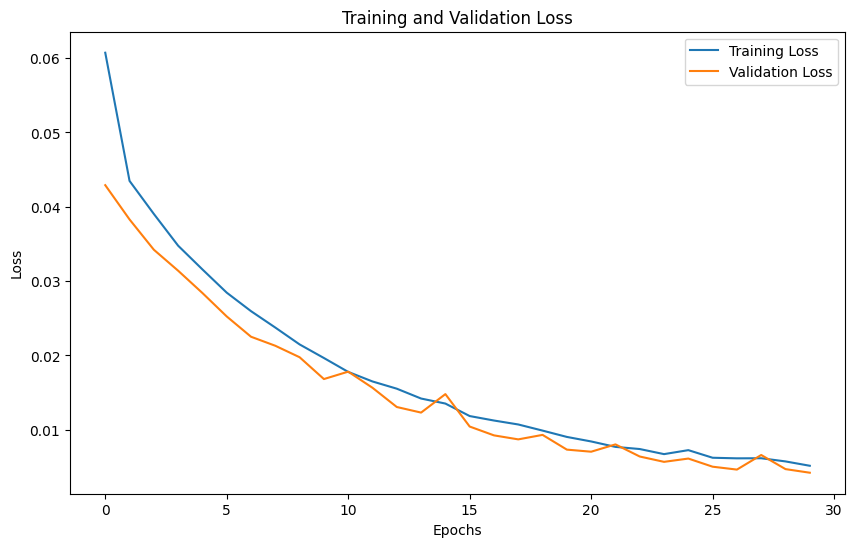

In [9]:
from tensorflow.keras.layers import GRU, Dense, Dropout
TARGET = "Close"
SEQ_SIZE = 30
PRED_SIZE = 1
EPOCH = 30
BATCH_SIZE = 16

def split_xy(dataset, time_steps, y_column):
    x, y = [], []
    for i in range(len(dataset) - time_steps - y_column):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column
        x.append(dataset.iloc[i:x_end_number, :].values)
        y.append(dataset.iloc[x_end_number:y_end_number, :][TARGET].values)
    return np.array(x), np.array(y)

X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
print(X[0], "\n", y[0])
print("X size:", X.shape)
print("y size:", y.shape)

# 시퀀스별로 Min-Max 정규화
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler.fit_transform(y)

# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 초기화 함수 정의
initializer = GlorotNormal()

# 모델 구성
model = Sequential()
model.add(GRU(128, input_shape=(SEQ_SIZE, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCH, validation_split=0.2, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model.predict(X_test)

# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

[[ 2.65000000e+05  2.72000000e+05  2.65000000e+05  2.68500000e+05
   1.54636000e+05  1.32075472e-02  2.65300000e+05  1.01206182e+00
   2.71550000e+05  9.88768183e-01  2.72850000e+05  9.84057174e-01
   2.77604167e+05  9.67204503e-01 -1.00000000e+00]
 [ 2.68500000e+05  2.71500000e+05  2.66500000e+05  2.70500000e+05
   1.46791000e+05  7.44878957e-03  2.66000000e+05  1.01691729e+00
   2.71375000e+05  9.96775679e-01  2.73108333e+05  9.90449455e-01
   2.77862500e+05  9.73503082e-01 -1.00000000e+00]
 [ 2.70000000e+05  2.74500000e+05  2.70000000e+05  2.72000000e+05
   1.92929000e+05  5.54528651e-03  2.68300000e+05  1.01379053e+00
   2.71025000e+05  1.00359745e+00  2.73483333e+05  9.94576147e-01
   2.78141667e+05  9.77918926e-01 -1.00000000e+00]
 [ 2.70000000e+05  2.73500000e+05  2.68000000e+05  2.70000000e+05
   1.60789000e+05 -7.35294118e-03  2.69200000e+05  1.00297177e+00
   2.70500000e+05  9.98151571e-01  2.73916667e+05  9.85701247e-01
   2.78362500e+05  9.69958238e-01 -1.00000000e+00]
 [ 2

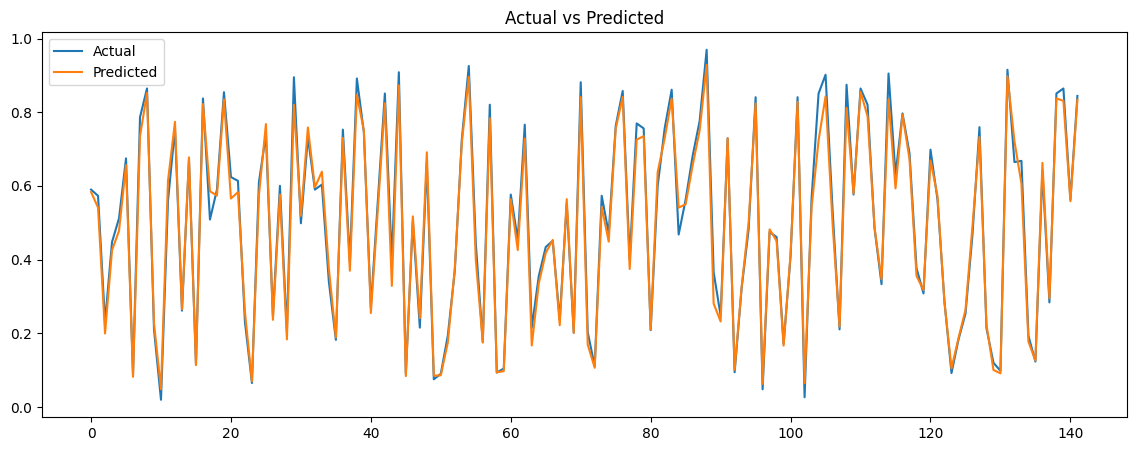

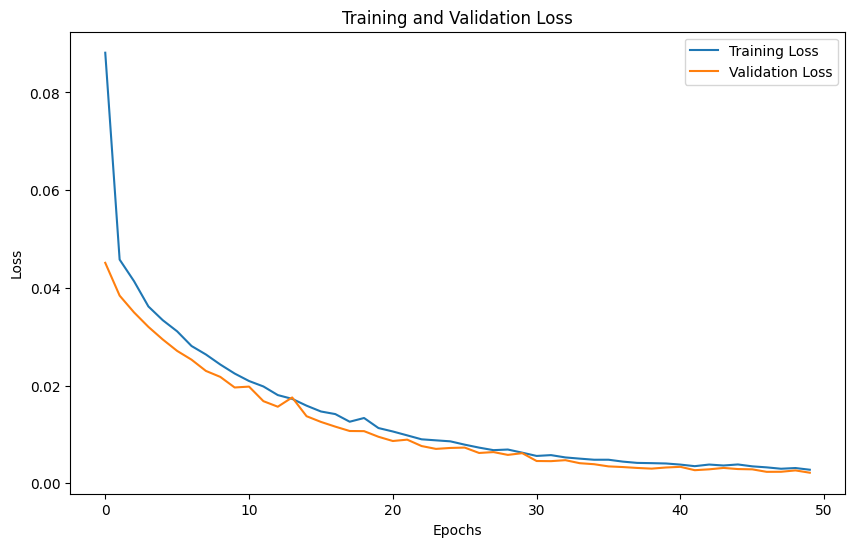

In [10]:
from tensorflow.keras.layers import GRU, Dense, Dropout
TARGET = "Close"
SEQ_SIZE = 30
PRED_SIZE = 1
EPOCH = 50
BATCH_SIZE = 16

def split_xy(dataset, time_steps, y_column):
    x, y = [], []
    for i in range(len(dataset) - time_steps - y_column):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column
        x.append(dataset.iloc[i:x_end_number, :].values)
        y.append(dataset.iloc[x_end_number:y_end_number, :][TARGET].values)
    return np.array(x), np.array(y)

X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
print(X[0], "\n", y[0])
print("X size:", X.shape)
print("y size:", y.shape)

# 시퀀스별로 Min-Max 정규화
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler.fit_transform(y)

# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 초기화 함수 정의
initializer = GlorotNormal()

# 모델 구성
model = Sequential()
model.add(GRU(128, input_shape=(SEQ_SIZE, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCH, validation_split=0.2, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model.predict(X_test)

# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()